# Team formation using MAB

In [13]:
# Omid55
import numpy as np
import random as rand
import scipy.stats as stat
import math
import itertools as itt
import collections
import matplotlib.pyplot as plt
import time
%matplotlib inline
import seaborn as sns

# Problem definition

In [2]:
'''Problem class'''
class Problem:
    # npeople
    # weights
    # team_size
    # optimal_team

    def __init__(self, npeople, team_size):
        self.npeople = npeople
        self.team_size = team_size
        self.all_possiblemap(int, team_str.split(','_teams = list(itt.combinations(range(0, self.npeople), self.team_size))
        self.weights = np.random.rand(npeople, npeople)
        self.weights = np.maximum(self.weights, self.weights.transpose())
        np.fill_diagonal(self.weights, 0)
        self.optimal_team = []
        self.STOCHASTICITY = 0.05

    def set_weights(self, weights):
        self.weights = weights

    def pull_arm(self, team):    # objective (fitness) function
        assert len(team) == self.team_size, 'team size should not be different than ' + self.team_size + ' .'
        prob = (1-self.STOCHASTICITY) * self.compute_value_of_team(team) / self.compute_value_of_team(self.optimal_team)
        return stat.bernoulli.rvs(prob)    #stat.binom.rvs(1, prob)

    def compute_value_of_team(self, team):
        w = 0.0
        c = 0.0
        for i in range(0, len(team)-1):
            for j in range(i+1, len(team)):
                w += self.weights[team[i]][team[j]]
                c += 1.0
        return w / c



# Optimal solution

In [3]:
'''Different methods for choosing team'''
# ground truth
def choose_optimal_team(problem, iterations):
    for it in range(iterations):
        if not problem.optimal_team:
            max_v = -999
            for team in problem.all_possible_teams:
                v = problem.compute_value_of_team(team)
                if v > max_v:
                    problem.optimal_team = team
                    max_v = v
            print('The optimal team is => ', problem.optimal_team, '\n')
        reward = problem.pull_arm(problem.optimal_team)
        yield team, reward


# Methods

In [4]:
def choose_team_by_random(problem, iterations):
    for it in range(iterations):
        team = rand.sample(range(problem.npeople), problem.team_size)
        reward = problem.pull_arm(team)
        yield team, reward

In [5]:
def choose_team_by_explore_few_then_exploit(problem, iterations):  # Maximum Likelihood
    exploration_percent = 10
    exploration_count = iterations * exploration_percent/100.0
    teams = []
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        if it < exploration_count:
            team = sorted(rand.sample(range(problem.npeople), problem.team_size))
            reward = problem.pull_arm(team)
            if reward == 1:
                S[str(team)[1:-1]] += 1
            else:
                F[str(team)[1:-1]] += 1
            yield team, reward
        else:
            if not teams:
                teams = list(set(list(S.keys())+list(F.keys())))
            prob = [S[a]/(S[a]+F[a]) for a in teams]
            team_str = teams[np.argmax(prob)]
            team = map(int, team_str.split(','))
            reward = problem.pull_arm(list(team))
            if reward == 1:
                S[team_str] += 1
            else:
                F[team_str] += 1
            yield team, reward

In [6]:
def choose_team_by_ucb(problem, iterations):
    tn = len(problem.all_possible_teams)
    assert iterations>tn, 'Number of iterations should be larger than number of teams.'
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for team in problem.all_possible_teams:
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward
    for it in range(iterations-tn):
        prob = [S[str(t)[1:-1]]/float(S[str(t)[1:-1]]+F[str(t)[1:-1]]) + math.sqrt(2*math.log(it+tn)/float(S[str(t)[1:-1]]+F[str(t)[1:-1]])) for t in problem.all_possible_teams]
        team = problem.all_possible_teams[np.argmax(prob)]
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward

In [7]:
def choose_team_by_thompson_sampling(problem, iterations):
    tn = len(problem.all_possible_teams)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        sampled_params = np.zeros(tn)
        for t, team in enumerate(problem.all_possible_teams):
            team_str = str(team)[1:-1]
            alpha = S[team_str] + 1
            beta = F[team_str] + 1
            sampled_params[t] = stat.beta.rvs(alpha, beta)
        team = problem.all_possible_teams[np.argmax(sampled_params)]
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward

In [8]:
def choose_team_by_ucb_with_random_variable_for_each_edge(problem, iterations):
    tn = len(problem.all_possible_teams)
    assert iterations>tn, 'Number of iterations should be larger than number of teams.'
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    # nn = 2.0 / (len(team) * (len(team)-1))
    nn = 1
    for team in problem.all_possible_teams:
        reward = problem.pull_arm(team)
        for i in range(0, len(team) - 1):
            for j in range(i + 1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S[edge] += nn
                    S[edge_rev] += nn
                else:
                    F[edge] += nn
                    F[edge_rev] += nn
        yield team, reward
    for it in range(iterations-tn):
        prob = np.zeros(tn)
        for index, team in enumerate(problem.all_possible_teams):
            for i in range(0, len(team) - 1):
                for j in range(i + 1, len(team)):
                    edge = str(team[i]) + ',' + str(team[j])
                    nk = float(S[edge]+F[edge])
                    prob[index] += S[edge] / nk + math.sqrt(2 * math.log(it + tn) / nk)
        team = problem.all_possible_teams[np.argmax(prob)]
        reward = problem.pull_arm(team)
        for i in range(0, len(team) - 1):
            for j in range(i + 1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S[edge] += nn
                    S[edge_rev] += nn
                else:
                    F[edge] += nn
                    F[edge_rev] += nn
        yield team, reward

In [9]:
def choose_team_by_thompson_sampling_with_random_variable_for_each_edge(problem, iterations):
    tn = len(problem.all_possible_teams)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    # nn = 2.0 / (len(team) * (len(team)-1))
    nn = 1
    for it in range(iterations):
        sampled_params = np.zeros(tn)
        for t, team in enumerate(problem.all_possible_teams):
            alpha = 1
            beta = 1
            for i in range(0,len(team)-1):
                for j in range(i+1, len(team)):
                    edge = str(team[i])+','+str(team[j])
                    # if S[edge] + F[edge] != 0:
                    #     alpha += S[edge] / (S[edge] + F[edge])
                    #     beta += F[edge] / (S[edge] + F[edge])
                    alpha += S[edge]
                    beta += F[edge]
            sampled_params[t] = stat.beta.rvs(alpha, beta)
        team = problem.all_possible_teams[np.argmax(sampled_params)]
        reward = problem.pull_arm(team)
        for i in range(0,len(team)-1):
            for j in range(i+1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S[edge] += nn
                    S[edge_rev] += nn
                else:
                    F[edge] += nn
                    F[edge_rev] += nn
        yield team, reward

[[ 0.          0.75794276  0.86082675  0.61111905  0.90273161  0.73935426
   0.61456989  0.96333153  0.39431502  0.74842578  0.96343552  0.73466503]
 [ 0.75794276  0.          0.35382837  0.99715354  0.88313803  0.771417
   0.8945574   0.88069097  0.26113005  0.75177328  0.45570918  0.92436175]
 [ 0.86082675  0.35382837  0.          0.84281577  0.87858308  0.16842444
   0.52867375  0.05678021  0.9014172   0.98987061  0.42753847  0.44301262]
 [ 0.61111905  0.99715354  0.84281577  0.          0.6205765   0.9950256
   0.98705116  0.46671805  0.83815165  0.86662102  0.52416501  0.89704719]
 [ 0.90273161  0.88313803  0.87858308  0.6205765   0.          0.45995997
   0.86732563  0.47825246  0.78795063  0.95080342  0.62407958  0.92974338]
 [ 0.73935426  0.771417    0.16842444  0.9950256   0.45995997  0.
   0.46196145  0.23830401  0.18965819  0.87580197  0.38496162  0.53359285]
 [ 0.61456989  0.8945574   0.52867375  0.98705116  0.86732563  0.46196145
   0.          0.950489    0.81321264  0.88

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


choose_team_by_random :	 0.7400000000000002 	+/-	 0.01 	: in  0.19  seconds.
choose_team_by_explore_few_then_exploit :	 0.8480000000000002 	+/-	 0.01 	: in  0.3  seconds.
choose_team_by_ucb :	 0.7429999999999997 	+/-	 0.01 	: in  7.08  seconds.
choose_team_by_thompson_sampling :	 0.7500000000000004 	+/-	 0.01 	: in  75.92  seconds.
choose_team_by_ucb_with_random_variable_for_each_edge :	 0.8015000000000004 	+/-	 0.01 	: in  28.4  seconds.
choose_team_by_thompson_sampling_with_random_variable_for_each_edge :	 0.8370000000000005 	+/-	 0.01 	: in  97.29  seconds.


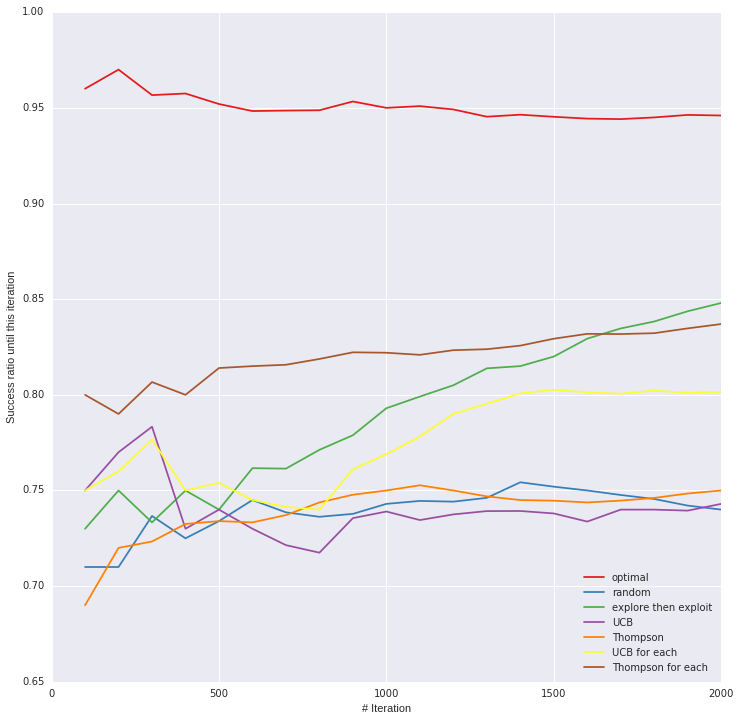

In [41]:
'''Main function'''
def main():

    # params
    number_of_people = 12
    team_size = 5
    iterations = 2000
    
    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set_palette("Set1", 8)
    probl = Problem(number_of_people, team_size)
    #probl.set_weights([[0,0.75,0.06,0.3,0.5], [0.75,0,0.88,0.46,0.95], [0.06,0.88,0,0.7,0.9], [0.3,0.46,0.7,0,0.02], [0.5,0.95,0.9,0.02,0]])  # comment it out to see diverse problems << CHECK HERE >>
    #probl.set_weights([[0, 0.1, 0.9, 0.2], [0.1, 0, 0.2, 0.3], [0.9, 0.2, 0, 0.3],[0.2, 0.3, 0.3, 0]])
    print(probl.weights, '\n\n')

    points = 20
    po = np.arange(iterations / points, iterations + iterations / points, iterations / points)
    methods = [choose_optimal_team, choose_team_by_random, choose_team_by_explore_few_then_exploit, choose_team_by_ucb, choose_team_by_thompson_sampling, choose_team_by_ucb_with_random_variable_for_each_edge, choose_team_by_thompson_sampling_with_random_variable_for_each_edge]
    for method in methods:
        start = time.time()
        rewards_mean = 0
        rewards_pow2_mean = 0
        success = np.zeros(points)
        cnt = 0.0
        win = 0.0
        for team, reward in method(probl, iterations):
            rewards_mean = float(rewards_mean * cnt + reward) / (cnt + 1)
            rewards_pow2_mean = float(rewards_pow2_mean * cnt + reward*reward) / (cnt + 1)
            if reward:
                win += 1.0
            cnt += 1.0
            if not cnt % (iterations/points):
                success[(cnt / (iterations/points))-1] = win / cnt

        sns.plt.plot(po, success)
        stand_err_r = round(math.sqrt(rewards_pow2_mean - rewards_mean*rewards_mean)/math.sqrt(iterations),2)
        print(method.__name__, ':\t', rewards_mean, '\t+/-\t', stand_err_r, '\t: in ', round(time.time() - start,2), ' seconds.')

    sns.axlabel('# Iteration', 'Success ratio until this iteration')
    sns.plt.legend(['optimal', 'random', 'explore then exploit', 'UCB', 'Thompson', 'UCB for each', 'Thompson for each'], loc='best')
    sns.plt.show()
    
    
# running the code
main()